In der Erstel Zelle:
1. pickle datei laden und daten extrahieren
2. die benötigten funktionen definieren

In der Zweiten Zelle:
1. bild laden
2. funktionen aufrufen
3. punktwolke speichern

In der Dritte Zelle:
1. punkte plotten

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import cv2

with open(r"G:\Meine Ablage\Studium\Master\3. Semester\Masterprojekt\Python Skripte\calibration_results_thinlaser.pkl", "rb") as f:
    data = pickle.load(f)

df = data["df"]
mtx = data["mtx"]
dist = data["dist"]
Plane_R = data["plane_right"]
PLANE_L = data["plane_left"]

path = r"G:\Meine Ablage\Studium\Master\3. Semester\Masterprojekt\Bilder\Bilder Kalibrierung Cropped\09_masked.png"

def pixel_to_cameraVector(u, v, K):
    pixelVector = np.array([u, v, 1])
    cameraVector = np.linalg.inv(K) @ (pixelVector )
    cameraVector = cameraVector / np.linalg.norm(cameraVector)
    return cameraVector
def get_intersection_Ray_Plane(cameraVector, plane_base, plane_normal):
    #Vereinfacht, da ursprung [0,0,0]
    lam = (plane_normal @ plane_base) / (plane_normal @ cameraVector)
    P = lam * cameraVector
    return P


Dauer: 0.000807 Sekunden


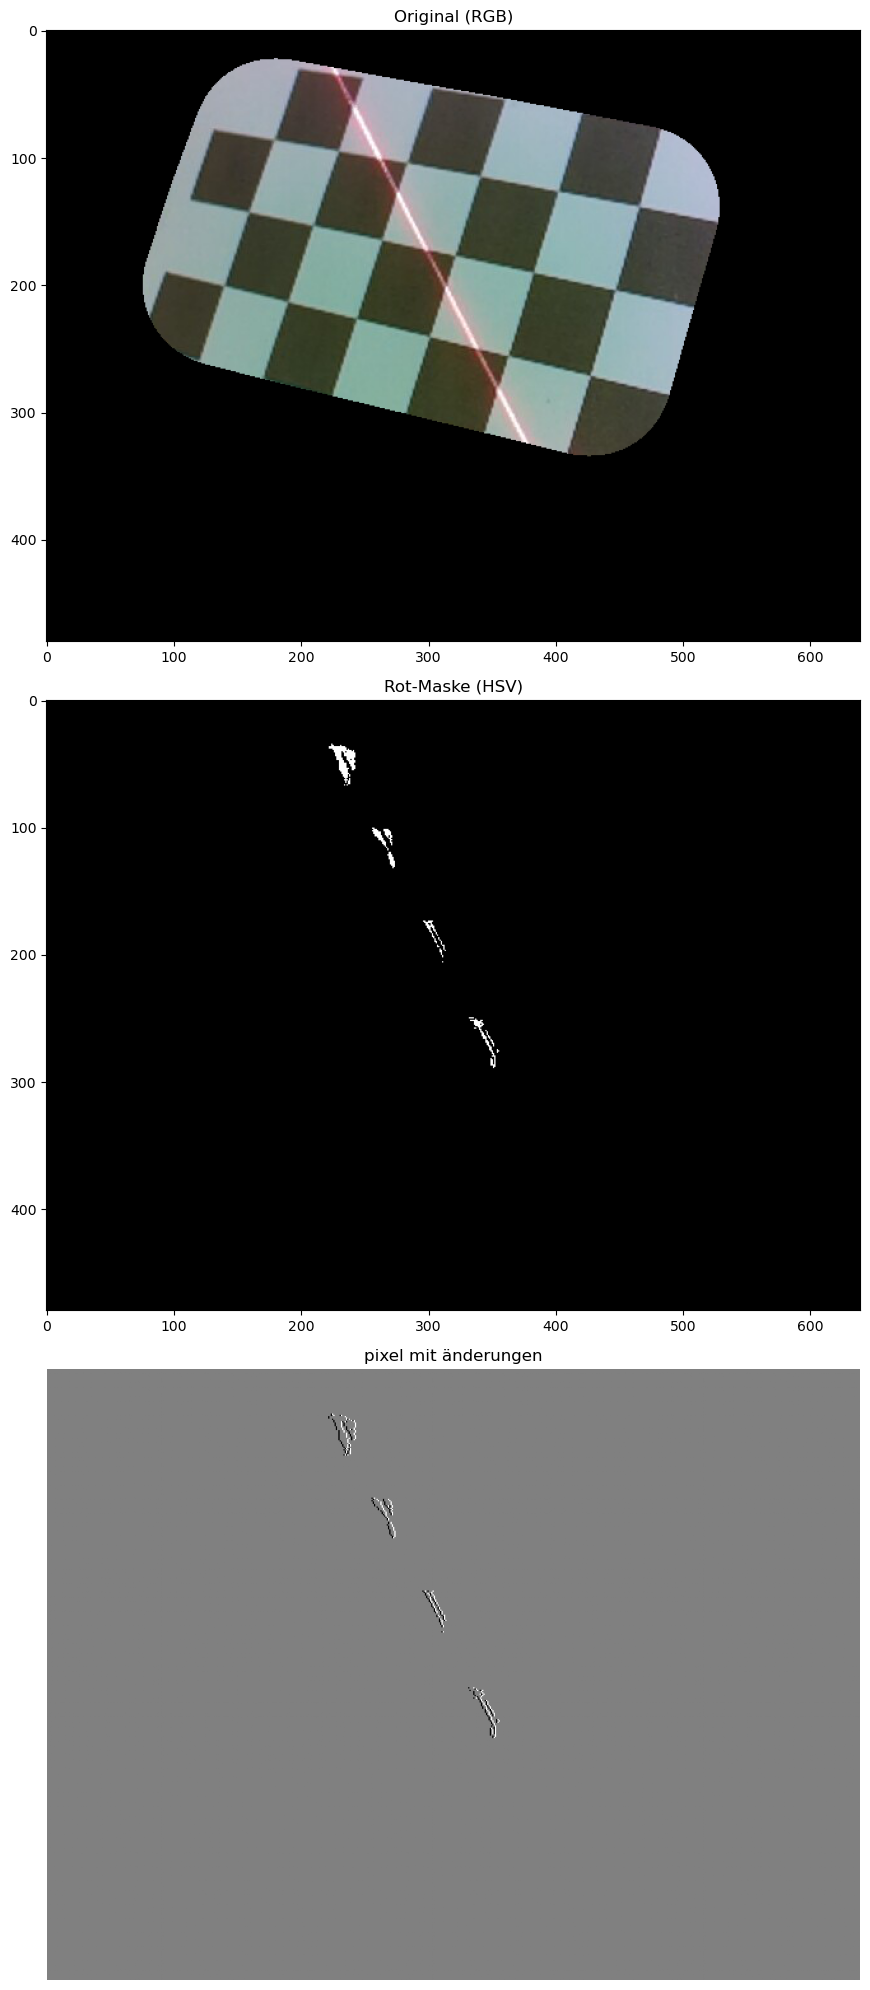

In [2]:
import pandas as pd
import time
plt.close("all")

%matplotlib inline


# Beispielvariablen
# print(Plane_R['centroid'], PLANE_L)

# --- Bild einlesen ---
img = cv2.imread(path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# --- In HSV konvertieren ---
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# --- Rotbereich definieren ---
# Achtung: In HSV ist Rot an beiden Enden des Hue-Spektrums (0° und 180°)
# Deshalb brauchen wir meist ZWEI Bereiche, die wir kombinieren.
lower_red1 = np.array([0, 100, 100])     # unterer Rotbereich
upper_red1 = np.array([10, 255, 255])
lower_red2 = np.array([160, 100, 100])   # oberer Rotbereich
upper_red2 = np.array([179, 255, 255])

# --- Masken erstellen und kombinieren ---
mask1 = cv2.inRange(img_hsv, lower_red1, upper_red1)
mask2 = cv2.inRange(img_hsv, lower_red2, upper_red2)
mask = cv2.bitwise_or(mask1, mask2)

#Zeit messen
start = time.perf_counter()
diff = np.diff(mask.astype(np.int8), axis=1)
end = time.perf_counter()

print(f"Dauer: {end - start:.6f} Sekunden")

# Collect coordinates and labels
ys_enter, xs_enter = np.where(diff == +1)
ys_leave, xs_leave = np.where(diff == -1)

records = []
# Note: np.diff produces differences for pairs (x-1, x), indexed at x in [1..W-1].
for y, x in zip(ys_enter, xs_enter + 1):  # +1 to shift to the right pixel index
    records.append({"y": int(y), "x": int(x), "transition": "to_red"})
for y, x in zip(ys_leave, xs_leave + 1):
    records.append({"y": int(y), "x": int(x), "transition": "from_red"})

df = pd.DataFrame.from_records(records).sort_values(["y", "x", "transition"]).reset_index(drop=True)


# --- Visualisierung ---
fig, axes = plt.subplots(3, 1, figsize=(30,20))
axes[0].imshow(img_rgb)
axes[0].set_title("Original (RGB)")
axes[1].imshow(mask, cmap="gray")
axes[1].set_title("Rot-Maske (HSV)")
axes[2].imshow(diff, cmap="gray")
axes[2].set_title("pixel mit änderungen")
plt.axis("off")
plt.tight_layout()
plt.show()




In [8]:
print(Plane_R['centroid'], PLANE_L)
plane_r_centroid = Plane_R['centroid']
plane_l_centroid = PLANE_L['centroid']
plane_r_normal = Plane_R['normal']
plane_l_normal = PLANE_L['normal']
points = []
for index, row in df.iterrows():
    y = row["y"]
    x = row["x"]
    transition = row["transition"]
    #checken zu welcher klasse die pixel gehören:
    cameraVector = pixel_to_cameraVector(y, x, mtx)
    if transition == "to_red":
        point = get_intersection_Ray_Plane(cameraVector, plane_r_centroid, plane_r_normal)

        points.append(point)
    elif transition == "from_red":
        point = get_intersection_Ray_Plane(cameraVector, plane_l_centroid, plane_l_normal)
        points.append(point)

    #print(f"Index {index}: y={y}, x={x}, Übergang={transition}")



[-31.30038261 -10.26521177 475.23444088] {'centroid': array([-32.6168797 ,  -7.4150206 , 473.99917136]), 'normal': array([ 0.70714668,  0.4096605 , -0.57630014])}


In [9]:
points = np.array(points).reshape((-1, 3))

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
#Plot setup
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.set_box_aspect([1,1,1])
def set_axes_equal(ax):
    '''Gleiche Skalierung für alle 3 Achsen'''
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    y_range = abs(y_limits[1] - y_limits[0])
    z_range = abs(z_limits[1] - z_limits[0])

    max_range = max([x_range, y_range, z_range]) / 2

    x_middle = np.mean(x_limits)
    y_middle = np.mean(y_limits)
    z_middle = np.mean(z_limits)

    ax.set_xlim3d([x_middle - max_range, x_middle + max_range])
    ax.set_ylim3d([y_middle - max_range, y_middle + max_range])
    ax.set_zlim3d([z_middle - max_range, z_middle + max_range])

ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='b', s=5)
set_axes_equal(ax)
#Ausrichtung wie in solidworks/3d kamerakonventionen
ax.view_init(elev=90, azim=-90)
# Axes labels and legend

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

<IPython.core.display.Javascript object>